# Training NN-model for tabular and image data
In this notebook we test whether considering not only tabular but also image satellite data can improve the accuracy of predictions.

This notebook is in partially very similar to "As in Paper v1.1.ipynb". Therefore, it includes less comments (only differences between notebooks are commented). Please get first familiar with "As in Paper v1.1.ipynb" before starting with this notebook. 

In [1]:
import tensorflow.keras as K
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

Make shure, you use GPU for training. CPU is extremely slow (but also a good GPU might need many hours for some code in this nodebook)

In [2]:
from tensorflow.python.client import device_lib
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(device_lib.list_local_devices())

Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15592557662618795088
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1743178958
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17221571425157541891
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [3]:
target_and_input_OpenLandMap = pd.read_csv("Target_and_input.csv")
target_and_input_OpenLandMap = target_and_input_OpenLandMap[target_and_input_OpenLandMap.olc_id != "5G55HPG4+MM7"]
target_and_input_OpenLandMap.shape

C:\Users\Philip\AppData\Local\Temp\ipykernel_26136\2470401199.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  target_and_input_OpenLandMap = pd.read_csv("Target_and_input.csv")


(69068, 106)

In [4]:
input_Sentinel_2 = pd.read_csv("pixels_df.csv")
input_Sentinel_2.shape

(15478, 14)

In [5]:
all_data = target_and_input_OpenLandMap.merge(input_Sentinel_2, on='olc_id', how='left')
all_data.shape

(69068, 119)

In [6]:
all_data.dropna(subset=['oc'], inplace=True)

In [7]:
all_data.drop(['uuid','confidence_degree','site_obsdate','source_db','layer_sequence.f','hzn_top', 'hzn_bot', 'n_tot', 'ph_h2o'], axis=1, inplace=True)

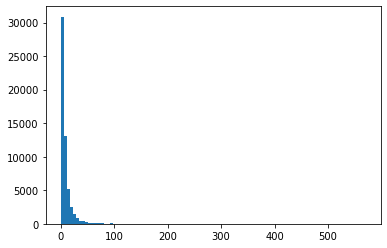

In [8]:
_ = plt.hist(all_data['oc'], bins=100)
plt.show()

In [9]:
all_data = all_data[all_data['oc'] < 120]  

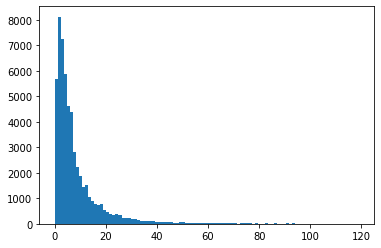

In [10]:
_ = plt.hist(all_data['oc'], bins=100)
plt.show()

In [11]:
train, validate, test = \
              np.split(all_data.sample(frac=1, random_state=42), 
                       [int(.6*len(all_data)), int(.8*len(all_data))])

In [12]:
all_data.shape, train.shape, validate.shape, test.shape

((55885, 110), (33531, 110), (11177, 110), (11177, 110))

In [13]:
train_targets = train["oc"]
validate_targets = validate["oc"]
test_targets = test["oc"]

train_targets = np.log(train_targets+1)
validate_targets = np.log(validate_targets+1)
test_targets = np.log(test_targets+1)

Tabular Input:

In [14]:
train_inputs_1 = train.drop(['oc', 'olc_id'], axis=1)
validate_inputs_1 = validate.drop(['oc', 'olc_id'], axis=1)
test_inputs_1 = test.drop(['oc', 'olc_id'], axis=1)

train_inputs_1.fillna(0, inplace = True)
validate_inputs_1.fillna(0, inplace = True)
test_inputs_1.fillna(0, inplace = True)

min_values = train_inputs_1.min(axis=0)
max_values = train_inputs_1.max(axis=0)

train_inputs_1=(train_inputs_1-min_values)/(max_values-min_values)
validate_inputs_1=(validate_inputs_1-min_values)/(max_values-min_values)
test_inputs_1=(test_inputs_1-min_values)/(max_values-min_values)

For image input, we need olc_id as reference:

In [15]:
train_inputs_2 = train["olc_id"]
validate_inputs_2 = validate["olc_id"]
test_inputs_2 = test["olc_id"]

In [16]:
train = pd.concat([train_targets, train_inputs_2, train_inputs_1], axis=1).reset_index(drop=True)
validate = pd.concat([validate_targets, validate_inputs_2, validate_inputs_1], axis=1).reset_index(drop=True)
test = pd.concat([test_targets, test_inputs_2, test_inputs_1], axis=1).reset_index(drop=True)

I have 32GB RAM but it is not sufficient to store all images. So, I defined an custom data generation function that loads only one batch of images (batch size is 32) into the RAM during the training process. I.e., images are loaded iteratively during the training. In the end of an epoche, the data points are shuffeled.

In [17]:
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, df,
                 batch_size,
                 shuffle = True):
        
        self.df = df.copy()
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        self.n = len(self.df)
        self.n_target = df['oc'].nunique()
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
            
    def __get_image_input(self, image):
        
        loaded_image = np.load("images/" + image + ".npz")["arr_0"]
        
        return K.applications.resnet50.preprocess_input(loaded_image)
    
    def __get_data(self, batches):
        # Generates data containing batch_size samples
        
        tabular_batch = batches.drop(['oc', 'olc_id'], axis=1)
        
        image_batch = batches["olc_id"]
        
        target_batch = batches["oc"]
        
        X1_batch = np.asarray(tabular_batch)
        
        X2_batch = np.asarray([self.__get_image_input(x) for x in image_batch])
        
        y_batch = np.asarray(target_batch)
        
        return [X1_batch, X2_batch], y_batch
    
    def __getitem__(self, index):
        
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)        
        
        return X, y
    
    def __len__(self):
        
        return self.n // self.batch_size

Define the actual model. It consists of two branches, one for tabular and one for image data.

The first branch operates on the first (tabular) input and is basically the pretrained model from the previous experiment ("As in Paper v1.1.ipynb"). But the last batch normalization layer and the layer for final prediction (that with linear activation function) are removed. So, the output of this branch is a 64-dimensional vector. All the coefficients of this branch are not trainable. We call this branch x.

In [18]:
x = K.models.load_model('model_as_in_paper_with_sentinel_regression.h5')

x = K.Model(x.inputs, x.layers[-3].output)

for layer in x.layers:
    layer.trainable = False
    print(layer.name, layer.trainable)

input_1 False
dense False
batch_normalization False
dense_1 False
batch_normalization_1 False
dense_2 False
batch_normalization_2 False
dense_3 False


The second branch is the famous ResNet50 model pretrained on ImageNet data set. Only the last classification layer is removed. We do not re-train ResNet50 and keep all coefficients not trainable. After reduction of dimensionality (a trainable dense layer), the output of this branch is connected to the output of the first branch and is fed into the final model.

In [23]:
res_model = K.applications.ResNet50(include_top = False,
                                  weights = "imagenet",
                                  input_tensor = K.Input(shape=(224,224,3,)))

for layer in res_model.layers[:175]:
    layer.trainable = False 
    
    
input_2 = K.Input(shape=(224,224,3,))
y = K.layers.RandomFlip(mode="horizontal_and_vertical", seed=123)(input_2)
y = res_model(y)
y = K.layers.Flatten()(y)
y = K.layers.Dense(32, name="dense_" , activation="relu")(y)
y = K.layers.BatchNormalization()(y)
y = K.Model(inputs=input_2, outputs=y)

In [24]:
# combine the output of the two branches
combined = K.layers.concatenate([x.output, y.output])


# apply a fully connected Dense layers and then a regression prediction on the
# combined outputs
z = K.layers.Dense(128, activation="relu")(combined)
z = K.layers.BatchNormalization()(z)
z = K.layers.Dense(64, activation="relu")(z)
z = K.layers.BatchNormalization()(z)
z = K.layers.Dense(32, activation="relu")(z)
z = K.layers.BatchNormalization()(z)
z = K.layers.Dense(1, activation="linear")(z)


# the model accepts the inputs of the two branches and
# then output a single value
model = K.Model(inputs=[x.input, y.input], outputs=z)

In [25]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 108)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          55808       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512)          2048        dense[0][0]                      
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
____________________________________________________________________________________________

We again use early stopping, but now patience is 10 (instead of 30). Otherwise calcualtion time is too big.

In [26]:
batch_siz = 32
num_epochs = 300
callback = K.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights = True)

In [27]:
model.compile(loss='mse',
              optimizer=K.optimizers.Adam(learning_rate=0.0001, #decay=0.000001
                                         )
             )

Use custom data generation function from above to generate batches of data

In [28]:
traingen = CustomDataGen(train,
                         batch_size=batch_siz)

valgen = CustomDataGen(validate,
                       batch_size=batch_siz)

In [29]:
history = model.fit(traingen,
                    validation_data=valgen,
                    epochs=num_epochs,
                    callbacks=[callback]
                   )

FileNotFoundError: [Errno 2] No such file or directory: 'images/6G5W6PH9+4H6.npz'

In [57]:
#model.save('model_with_images_regression.h5')

C:\Users\sprin\anaconda3\envs\ML\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


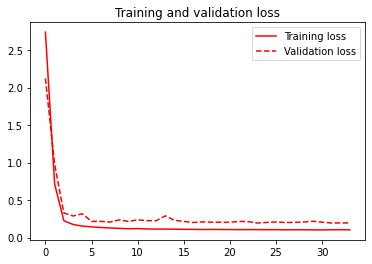

In [55]:
import matplotlib.pyplot as plt

#acc = history.history['accuracy']
#val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

#plt.plot(epochs, acc, 'b', label='Training acc')
#plt.plot(epochs, val_acc, 'b--', label='Validation acc')
#plt.title('Training and validation accuracy')
#plt.legend()

#plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'r--', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Create a custom data generation function also for predictions. It is the same as function for training but does not shuffle data.

In [58]:
class CustomPredGen(tf.keras.utils.Sequence):
    
    def __init__(self, df,
                 batch_size,
                 shuffle = False):
        
        self.df = df.copy()
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        self.n = len(self.df)
        self.n_target = df['oc'].nunique()
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
            
    def __get_image_input(self, image):
        
        loaded_image = np.load("images/" + image + ".npz")["arr_0"]
        
        return K.applications.resnet50.preprocess_input(loaded_image)
    
    def __get_data(self, batches):
        # Generates data containing batch_size samples
        
        tabular_batch = batches.drop(['oc', 'olc_id'], axis=1)
        
        image_batch = batches["olc_id"]
        
        target_batch = batches["oc"]
        
        X1_batch = np.asarray(tabular_batch)
        
        X2_batch = np.asarray([self.__get_image_input(x) for x in image_batch])
        
        return [X1_batch, X2_batch]
    
    def __getitem__(self, index):
        
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X = self.__get_data(batches)        
        
        return X
    
    def __len__(self):
        
        return self.n // self.batch_size

In [59]:
#Required if model is loaded

#batch_siz = 32
#model = K.models.load_model('model_with_images_regression.h5')
#model.summary()

In [60]:
train_predictions = pd.DataFrame(model.predict(CustomPredGen(train,batch_size=batch_siz)))

In [61]:
train_df = pd.DataFrame(train["oc"][0:33504]) # since we lose a couple of points due to batches, modify also the original df

In [62]:
train_predictions.clip(lower=0, inplace=True)

In [63]:
np.sqrt(np.square(train_predictions[0] - train_df["oc"]).sum(axis=0)/train_df.shape[0])

0.28378329592571

In [64]:
(np.round(train_predictions[0]) == np.round(train_df["oc"])).sum(axis=0)/train_df.shape[0]

0.794114135625597

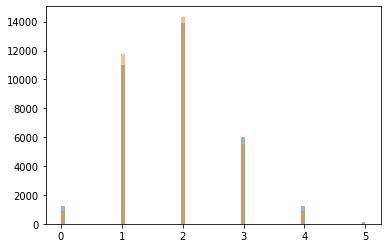

In [65]:
_ = plt.hist(np.round(train_df), bins='auto', alpha=0.5)  # arguments are passed to np.histogram
_ = plt.hist(np.round(train_predictions), bins='auto', alpha=0.5)
plt.show()

In [67]:
validate_predictions = pd.DataFrame(model.predict(CustomPredGen(validate,batch_size=batch_siz)))

In [68]:
validate_df = pd.DataFrame(validate["oc"][0:11168])

In [69]:
validate_predictions.clip(lower=0, inplace=True)

In [70]:
np.sqrt(np.square(validate_predictions[0] - validate_df["oc"]).sum(axis=0)/validate_df.shape[0])

0.4394987090645643

In [71]:
(np.round(validate_predictions[0]) == np.round(validate_df["oc"])).sum(axis=0)/validate_df.shape[0]

0.6943946991404012

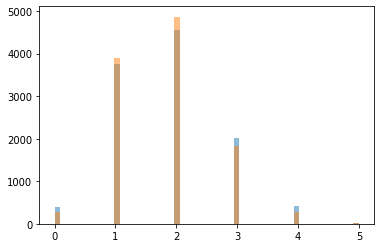

In [72]:
_ = plt.hist(np.round(validate_df), bins='auto', alpha=0.5)  # arguments are passed to np.histogram
_ = plt.hist(np.round(validate_predictions), bins='auto', alpha=0.5)
plt.show()

In [74]:
test_predictions = pd.DataFrame(model.predict(CustomPredGen(test,batch_size=batch_siz)))

In [75]:
test_df = pd.DataFrame(test["oc"][0:11168])

In [76]:
test_predictions.clip(lower=0, inplace=True)

In [77]:
np.sqrt(np.square(test_predictions[0] - test_df["oc"]).sum(axis=0)/test_df.shape[0])

0.43568125618742437

In [78]:
(np.round(test_predictions[0]) == np.round(test_df["oc"])).sum(axis=0)/test_df.shape[0]

0.7003939828080229

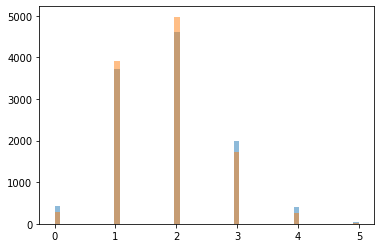

In [79]:
_ = plt.hist(np.round(test_df), bins='auto', alpha=0.5)  # arguments are passed to np.histogram
_ = plt.hist(np.round(test_predictions), bins='auto', alpha=0.5)
plt.show()

## Summary for one model
 - RMSE
   - Train: 0.28378329592571
   - Valid: 0.4394987090645643
   - Test: 0.43568125618742437

 - Accuracy (rounded in classes)
   - Train: 0.794114135625597
   - Valid: 0.6943946991404012
   - Test: 0.7003939828080229

## Error Estimation
Now, as already mentioned above we repeat the same process 10 times to estimate the error of our metrices. Thereby, different seeds are used to split the data

In [6]:
seeds = [24,3,123,7,666,5,10,1993,13,12]

Before running the code below, make shure that classes CustomDataGen and CustomPredGen are loaded.
ATTENTION: on my GPU, NVIDIA GeForce RTX 3080 with 16GB, this code needs ca 18-19 hours. On CPU, it might need factor 2-10 longer (I did not test it).

In [11]:
rmse_train = []
rmse_valid = []
rmse_test = []

acc_train = []
acc_valid = []
acc_test = []

for i in seeds:
    target_and_input_OpenLandMap = pd.read_csv("Target_and_input.csv")
    target_and_input_OpenLandMap = target_and_input_OpenLandMap[target_and_input_OpenLandMap.olc_id != "5G55HPG4+MM7"]
    input_Sentinel_2 = pd.read_csv("pixels_df.csv")
    all_data = target_and_input_OpenLandMap.merge(input_Sentinel_2, on='olc_id', how='left')
    all_data.dropna(subset=['oc'], inplace=True)
    all_data.drop(['uuid','confidence_degree','site_obsdate','source_db','layer_sequence.f','hzn_top', 'hzn_bot', 'n_tot', 'ph_h2o'],
                  axis=1, inplace=True)
    all_data = all_data[all_data['oc'] < 120] 
       
    train, validate, test = \
              np.split(all_data.sample(frac=1, random_state=i), 
                       [int(.6*len(all_data)), int(.8*len(all_data))])
    
    train_targets = train["oc"]
    validate_targets = validate["oc"]
    test_targets = test["oc"]
    
    train_targets = np.log(train_targets+1)
    validate_targets = np.log(validate_targets+1)
    test_targets = np.log(test_targets+1)
    
    train_inputs_1 = train.drop(['oc', 'olc_id'], axis=1)
    validate_inputs_1 = validate.drop(['oc', 'olc_id'], axis=1)
    test_inputs_1 = test.drop(['oc', 'olc_id'], axis=1)
    
    train_inputs_1.fillna(0, inplace = True)
    validate_inputs_1.fillna(0, inplace = True)
    test_inputs_1.fillna(0, inplace = True)
    
    min_values = train_inputs_1.min(axis=0)
    max_values = train_inputs_1.max(axis=0)
    
    train_inputs_1=(train_inputs_1-min_values)/(max_values-min_values)
    validate_inputs_1=(validate_inputs_1-min_values)/(max_values-min_values)
    test_inputs_1=(test_inputs_1-min_values)/(max_values-min_values)
    
    train_inputs_2 = train["olc_id"]
    validate_inputs_2 = validate["olc_id"]
    test_inputs_2 = test["olc_id"]
    
    train = pd.concat([train_targets, train_inputs_2, train_inputs_1], axis=1).reset_index(drop=True)
    validate = pd.concat([validate_targets, validate_inputs_2, validate_inputs_1], axis=1).reset_index(drop=True)
    test = pd.concat([test_targets, test_inputs_2, test_inputs_1], axis=1).reset_index(drop=True)
    
    #Model
    x = K.models.load_model('Models_eval_as_in_paper/model_without_images_regression_seed_'+str(i)+'.h5')
    x = K.Model(x.inputs, x.layers[-3].output)
    
    for layer in x.layers:
        layer.trainable = False
        
    res_model = K.applications.ResNet50(include_top = False,
                                  weights = "imagenet",
                                  input_tensor = K.Input(shape=(224,224,3,)))
    
    for layer in res_model.layers[:175]:
        layer.trainable = False 
        
    input_2 = K.Input(shape=(224,224,3,))
    y = K.layers.RandomFlip(mode="horizontal_and_vertical", seed=123)(input_2)
    y = res_model(y)
    y = K.layers.Flatten()(y)
    y = K.layers.Dense(32, activation="relu")(y)
    y = K.layers.BatchNormalization()(y)
    y = K.Model(inputs=input_2, outputs=y)
    
    combined = K.layers.concatenate([x.output, y.output])
    
    z = K.layers.Dense(128, activation="relu")(combined)
    z = K.layers.BatchNormalization()(z)
    z = K.layers.Dense(64, activation="relu")(z)
    z = K.layers.BatchNormalization()(z)
    z = K.layers.Dense(32, activation="relu")(z)
    z = K.layers.BatchNormalization()(z)
    z = K.layers.Dense(1, activation="linear")(z)
    
    model = K.Model(inputs=[x.input, y.input], outputs=z)

    
    batch_siz = 32
    num_epochs = 300
    callback = K.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights = True)
    
    model.compile(loss='mse',
              optimizer=K.optimizers.Adam(learning_rate=0.0001, #decay=0.000001
                                         ),
              #metrics=['accuracy']
             )
    
    traingen = CustomDataGen(train,
                             batch_size=batch_siz)
    valgen = CustomDataGen(validate,
                           batch_size=batch_siz)
    
    history = model.fit(traingen,
                        validation_data=valgen,
                        epochs=num_epochs,
                        callbacks=[callback]
                       )
    
    
    train_predictions = pd.DataFrame(model.predict(CustomPredGen(train,batch_size=batch_siz)))
    train_df = pd.DataFrame(train["oc"][0:33504])
    train_predictions.clip(lower=0, inplace=True)
    
    rmse_train.append(np.sqrt(np.square(train_predictions[0] - train_df["oc"]).sum(axis=0)/train_df.shape[0]))
    acc_train.append((np.round(train_predictions[0]) == np.round(train_df["oc"])).sum(axis=0)/train_df.shape[0])
    
    validate_predictions = pd.DataFrame(model.predict(CustomPredGen(validate,batch_size=batch_siz)))
    validate_df = pd.DataFrame(validate["oc"][0:11168])
    validate_predictions.clip(lower=0, inplace=True)
    
    rmse_valid.append(np.sqrt(np.square(validate_predictions[0] - validate_df["oc"]).sum(axis=0)/validate_df.shape[0]))
    acc_valid.append((np.round(validate_predictions[0]) == np.round(validate_df["oc"])).sum(axis=0)/validate_df.shape[0])
    
    test_predictions = pd.DataFrame(model.predict(CustomPredGen(test,batch_size=batch_siz)))
    test_df = pd.DataFrame(test["oc"][0:11168])
    test_predictions.clip(lower=0, inplace=True)
    
    rmse_test.append(np.sqrt(np.square(test_predictions[0] - test_df["oc"]).sum(axis=0)/test_df.shape[0]))
    acc_test.append((np.round(test_predictions[0]) == np.round(test_df["oc"])).sum(axis=0)/test_df.shape[0])
    
    model.save('Models_eval_Combined_Input_Source/model_with_images_regression_seed_'+str(i)+'.h5')

    print(i)

Epoch 1/300
1047/1047 [==============================] - 240s 221ms/step - loss: 2.7055 - val_loss: 214.1637
Epoch 2/300
1047/1047 [==============================] - 138s 132ms/step - loss: 0.7196 - val_loss: 0.6307
Epoch 3/300
1047/1047 [==============================] - 184s 176ms/step - loss: 0.2492 - val_loss: 0.3760
Epoch 4/300
1047/1047 [==============================] - 162s 155ms/step - loss: 0.1973 - val_loss: 0.3266
Epoch 5/300
1047/1047 [==============================] - 137s 131ms/step - loss: 0.1796 - val_loss: 0.2754
Epoch 6/300
1047/1047 [==============================] - 138s 131ms/step - loss: 0.1682 - val_loss: 0.7761
Epoch 7/300
1047/1047 [==============================] - 139s 132ms/step - loss: 0.1608 - val_loss: 0.3243
Epoch 8/300
1047/1047 [==============================] - 143s 136ms/step - loss: 0.1534 - val_loss: 0.5796
Epoch 9/300
1047/1047 [==============================] - 137s 131ms/step - loss: 0.1497 - val_loss: 0.2340
Epoch 10/300
1047/1047 [===========

C:\Users\sprin\anaconda3\envs\ML\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


24
Epoch 1/300
1047/1047 [==============================] - 142s 132ms/step - loss: 2.7397 - val_loss: 1.8735
Epoch 2/300
1047/1047 [==============================] - 137s 131ms/step - loss: 0.7163 - val_loss: 0.4817
Epoch 3/300
1047/1047 [==============================] - 140s 134ms/step - loss: 0.2230 - val_loss: 0.5973
Epoch 4/300
1047/1047 [==============================] - 138s 132ms/step - loss: 0.1733 - val_loss: 0.2978
Epoch 5/300
1047/1047 [==============================] - 140s 133ms/step - loss: 0.1572 - val_loss: 0.3681
Epoch 6/300
1047/1047 [==============================] - 142s 136ms/step - loss: 0.1457 - val_loss: 0.2224
Epoch 7/300
1047/1047 [==============================] - 204s 195ms/step - loss: 0.1398 - val_loss: 0.4505
Epoch 8/300
1047/1047 [==============================] - 142s 135ms/step - loss: 0.1349 - val_loss: 0.4773
Epoch 9/300
1047/1047 [==============================] - 137s 131ms/step - loss: 0.1295 - val_loss: 0.2334
Epoch 10/300
1047/1047 [==========

1047/1047 [==============================] - 143s 137ms/step - loss: 0.1083 - val_loss: 0.2197
Epoch 41/300
1047/1047 [==============================] - 152s 145ms/step - loss: 0.1082 - val_loss: 0.2110
Epoch 42/300
1047/1047 [==============================] - 143s 137ms/step - loss: 0.1082 - val_loss: 0.2002
Epoch 43/300
1047/1047 [==============================] - 155s 148ms/step - loss: 0.1085 - val_loss: 0.2052
Epoch 44/300
1047/1047 [==============================] - 143s 137ms/step - loss: 0.1082 - val_loss: 0.2067
Epoch 45/300
1047/1047 [==============================] - 152s 145ms/step - loss: 0.1072 - val_loss: 0.1983
666
Epoch 1/300
1047/1047 [==============================] - 152s 142ms/step - loss: 2.7101 - val_loss: 3.2855
Epoch 2/300
1047/1047 [==============================] - 153s 146ms/step - loss: 0.6855 - val_loss: 0.7051
Epoch 3/300
1047/1047 [==============================] - 145s 138ms/step - loss: 0.2322 - val_loss: 0.6777
Epoch 4/300
1047/1047 [=================

1047/1047 [==============================] - 143s 137ms/step - loss: 0.1071 - val_loss: 0.1985
Epoch 31/300
1047/1047 [==============================] - 150s 143ms/step - loss: 0.1018 - val_loss: 0.2013
Epoch 32/300
1047/1047 [==============================] - 146s 140ms/step - loss: 0.1015 - val_loss: 0.2058
Epoch 33/300
1047/1047 [==============================] - 147s 140ms/step - loss: 0.1030 - val_loss: 0.2091
Epoch 34/300
1047/1047 [==============================] - 147s 140ms/step - loss: 0.1037 - val_loss: 0.2024
Epoch 35/300
1047/1047 [==============================] - 149s 142ms/step - loss: 0.1022 - val_loss: 0.1976
Epoch 36/300
1047/1047 [==============================] - 144s 137ms/step - loss: 0.1012 - val_loss: 0.2009
Epoch 37/300
1047/1047 [==============================] - 146s 139ms/step - loss: 0.1035 - val_loss: 0.2005
Epoch 38/300
1047/1047 [==============================] - 143s 136ms/step - loss: 0.1015 - val_loss: 0.2004
Epoch 39/300
1047/1047 [=================

1047/1047 [==============================] - 146s 139ms/step - loss: 0.1080 - val_loss: 0.1948
Epoch 22/300
1047/1047 [==============================] - 144s 138ms/step - loss: 0.1081 - val_loss: 0.1934
Epoch 23/300
1047/1047 [==============================] - 144s 137ms/step - loss: 0.1070 - val_loss: 0.2039
Epoch 24/300
1047/1047 [==============================] - 144s 138ms/step - loss: 0.1056 - val_loss: 0.2015
Epoch 25/300
1047/1047 [==============================] - 149s 142ms/step - loss: 0.1062 - val_loss: 0.1980
Epoch 26/300
1047/1047 [==============================] - 144s 137ms/step - loss: 0.1042 - val_loss: 0.1961
Epoch 27/300
1047/1047 [==============================] - 150s 143ms/step - loss: 0.1047 - val_loss: 0.2064
Epoch 28/300
1047/1047 [==============================] - 144s 137ms/step - loss: 0.1072 - val_loss: 0.4015
Epoch 29/300
1047/1047 [==============================] - 149s 142ms/step - loss: 0.1043 - val_loss: 0.2018
Epoch 30/300
1047/1047 [=================

In [12]:
rmse_train

[0.32131005005679175,
 0.2914595003961931,
 0.269508979274405,
 0.29939520928942764,
 0.2898124773527674,
 0.28179312077333685,
 0.28336765802273534,
 0.28394492886447426,
 0.27770242645861803,
 0.29017155854041615]

In [13]:
acc_train

[0.7673710601719198,
 0.7895176695319962,
 0.8054560649474689,
 0.7822349570200573,
 0.7913383476599809,
 0.7970391595033429,
 0.791248806112703,
 0.7933978032473734,
 0.7990687679083095,
 0.7893982808022922]

In [14]:
rmse_valid

[0.4463641571968481,
 0.443278121833637,
 0.44356066824095064,
 0.4399865104751898,
 0.4411733241575992,
 0.44070664333071485,
 0.4446573458287871,
 0.43619222681561026,
 0.4365567746830732,
 0.4386040789545298]

In [15]:
acc_valid

[0.6856196275071633,
 0.6946633237822349,
 0.6958273638968482,
 0.6880372492836676,
 0.6943051575931232,
 0.6923352435530086,
 0.6940365329512894,
 0.6997671919770774,
 0.6953796561604585,
 0.6977077363896849]

In [16]:
rmse_test

[0.45767762502076276,
 0.4392500846005559,
 0.4349267904246865,
 0.44188495324433874,
 0.4371186210710677,
 0.43234531889925565,
 0.435803444488765,
 0.4361156136290402,
 0.4363038842526551,
 0.448349641822445]

In [17]:
acc_test

[0.6823961318051576,
 0.6883954154727794,
 0.6993194842406877,
 0.6852614613180515,
 0.698871776504298,
 0.6995881088825215,
 0.6959169054441261,
 0.6942156160458453,
 0.6934992836676218,
 0.6890222063037249]

In [18]:
results_errors = pd.DataFrame({'seeds':seeds,
                               'rmse_train': rmse_train, 'acc_train': acc_train,
                              'rmse_valid': rmse_valid, 'acc_valid': acc_valid,
                              'rmse_test': rmse_test, 'acc_test': acc_test})

In [19]:
results_errors

,seeds,rmse_train,acc_train,rmse_valid,acc_valid,rmse_test,acc_test
0,24,0.321310,0.767371,0.446364,0.685620,0.457678,0.682396
1,3,0.291460,0.789518,0.443278,0.694663,0.439250,0.688395
2,123,0.269509,0.805456,0.443561,0.695827,0.434927,0.699319
3,7,0.299395,0.782235,0.439987,0.688037,0.441885,0.685261
4,666,0.289812,0.791338,0.441173,0.694305,0.437119,0.698872
5,5,0.281793,0.797039,0.440707,0.692335,0.432345,0.699588
6,10,0.283368,0.791249,0.444657,0.694037,0.435803,0.695917
7,1993,0.283945,0.793398,0.436192,0.699767,0.436116,0.694216
8,13,0.277702,0.799069,0.436557,0.695380,0.436304,0.693499
9,12,0.290172,0.789398,0.438604,0.697708,0.448350,0.689022


In [20]:
results_errors.min(axis=0)

seeds         3.000000
rmse_train    0.269509
acc_train     0.767371
rmse_valid    0.436192
acc_valid     0.685620
rmse_test     0.432345
acc_test      0.682396
dtype: float64

In [21]:
results_errors.max(axis=0)

seeds         1993.000000
rmse_train       0.321310
acc_train        0.805456
rmse_valid       0.446364
acc_valid        0.699767
rmse_test        0.457678
acc_test         0.699588
dtype: float64

In [22]:
#results_errors.to_csv('Combined_Input_Source_results_errors_reg.csv', index=False)  

Now, also add results from the oiginal model

In [82]:
Combined_Input_Source_results_errors_reg = pd.read_csv("Combined_Input_Source_results_errors_reg.csv")

In [83]:
Combined_Input_Source_results_errors_reg

,seeds,rmse_train,acc_train,rmse_valid,acc_valid,rmse_test,acc_test
0,24,0.321310,0.767371,0.446364,0.685620,0.457678,0.682396
1,3,0.291460,0.789518,0.443278,0.694663,0.439250,0.688395
2,123,0.269509,0.805456,0.443561,0.695827,0.434927,0.699319
3,7,0.299395,0.782235,0.439987,0.688037,0.441885,0.685261
4,666,0.289812,0.791338,0.441173,0.694305,0.437119,0.698872
5,5,0.281793,0.797039,0.440707,0.692335,0.432345,0.699588
6,10,0.283368,0.791249,0.444657,0.694037,0.435803,0.695917
7,1993,0.283945,0.793398,0.436192,0.699767,0.436116,0.694216
8,13,0.277702,0.799069,0.436557,0.695380,0.436304,0.693499
9,12,0.290172,0.789398,0.438604,0.697708,0.448350,0.689022


In [84]:
Combined_Input_Source_results_errors_reg = Combined_Input_Source_results_errors_reg.append({'seeds': 42, 'rmse_train': 0.28378329592571, 'acc_train': 0.794114135625597,
                                   'rmse_valid': 0.4394987090645643, 'acc_valid': 0.6943946991404012,
                                   'rmse_test': 0.43568125618742437, 'acc_test': 0.7003939828080229}, ignore_index = True)

In [86]:
Combined_Input_Source_results_errors_reg

,seeds,rmse_train,acc_train,rmse_valid,acc_valid,rmse_test,acc_test
0,24.0,0.321310,0.767371,0.446364,0.685620,0.457678,0.682396
1,3.0,0.291460,0.789518,0.443278,0.694663,0.439250,0.688395
2,123.0,0.269509,0.805456,0.443561,0.695827,0.434927,0.699319
3,7.0,0.299395,0.782235,0.439987,0.688037,0.441885,0.685261
4,666.0,0.289812,0.791338,0.441173,0.694305,0.437119,0.698872
5,5.0,0.281793,0.797039,0.440707,0.692335,0.432345,0.699588
6,10.0,0.283368,0.791249,0.444657,0.694037,0.435803,0.695917
7,1993.0,0.283945,0.793398,0.436192,0.699767,0.436116,0.694216
8,13.0,0.277702,0.799069,0.436557,0.695380,0.436304,0.693499
9,12.0,0.290172,0.789398,0.438604,0.697708,0.448350,0.689022


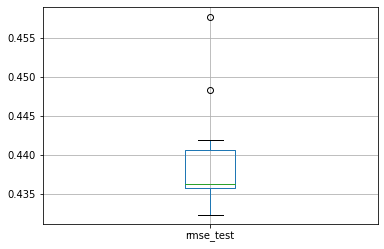

In [87]:
boxplot = Combined_Input_Source_results_errors_reg.boxplot(column=["rmse_test"])

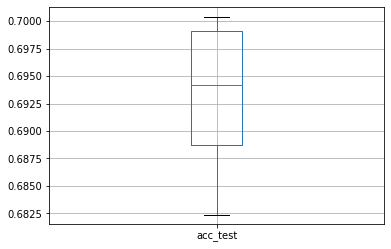

In [88]:
boxplot = Combined_Input_Source_results_errors_reg.boxplot(column=["acc_test"])

Plot together with results from "As in Paper v1.1.ipynb"

In [89]:
as_paper_results_errors_reg = pd.read_csv("as_paper_results_errors_reg.csv")
as_paper_results_errors_reg = as_paper_results_errors_reg.append({'seeds': 42, 'rmse_train': 0.290209, 'acc_train': 0.789836,
                                   'rmse_valid': 0.444209, 'acc_valid': 0.692494,
                                   'rmse_test': 0.439565, 'acc_test': 0.699472}, ignore_index = True)

In [92]:
to_compare = pd.DataFrame({"rmse_only_tabular":as_paper_results_errors_reg['rmse_test'],
                          "acc_only_tabular":as_paper_results_errors_reg['acc_test'],
                          "rmse_with_images":Combined_Input_Source_results_errors_reg['rmse_test'],
                          "acc_with_Images":Combined_Input_Source_results_errors_reg['acc_test']})

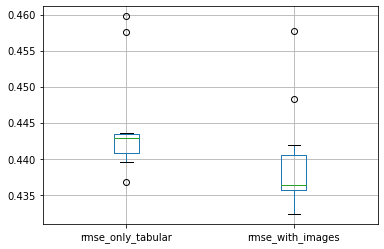

In [95]:
boxplot = to_compare.boxplot(column=["rmse_only_tabular","rmse_with_images"])

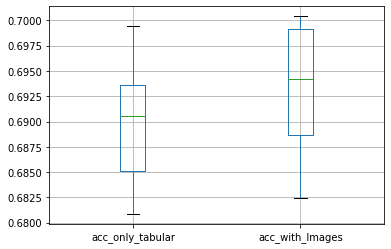

In [97]:
boxplot = to_compare.boxplot(column=["acc_only_tabular","acc_with_Images"])

The improvement is present but is marginal.

The reason for that seems to be bad quality of the images in the first place: there are images with a lot of clouds and images created by night. Sometime both.

The fact that there are clouds on images is very strange, because while doing API calls to Sentinel Hub we say: “take an image from the last two month with lowest cloud coverage”. It looks like some areas are very cloudy. Maybe we should consider more than 2 months. I have no idea how to control whether day- or nighttime images are downloaded. I have to read documentation more carefully. In any case, the problem seems to be quite big: from 10 images I randomly looked at, 4 were trash. 

Of course, the quality of images has a large impact on the results. We should pay more attention on data preparation. But it will be probably not an easy task since we will have to look at thousands of images manually and try to identify all reasons for bad quality of images and try to find corresponding solution. Here we might have to acquire some better understanding of satellite imagery in general.

In any case, increasing quality of images is the next step in the project.

Aelow is some good and some bad examples of images

Examples for good quality:

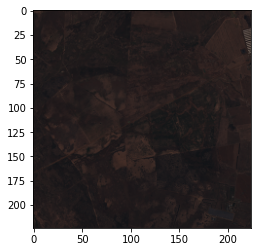

In [3]:
import matplotlib.pyplot as plt
image = np.load("images/4FRWMG86+VQP.npz")["arr_0"]
plt.imshow(image)

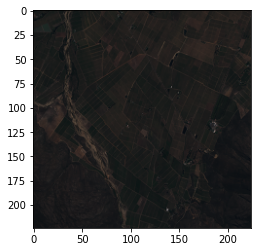

In [99]:
import matplotlib.pyplot as plt
image = np.load("images/4FRX78HM+VMM.npz")["arr_0"]
plt.imshow(image)

Rather bad quality:

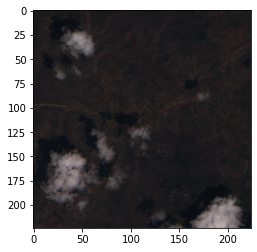

In [109]:
import matplotlib.pyplot as plt
image = np.load("images/6G6V7F52+4GG.npz")["arr_0"]
plt.imshow(image)

Definitely bad quality:

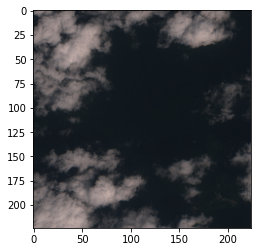

In [102]:
import matplotlib.pyplot as plt
image = np.load("images/6FJGRMMF+686.npz")["arr_0"]
plt.imshow(image)

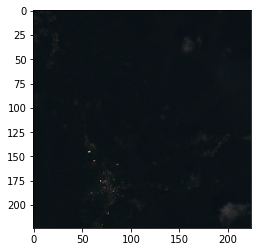

In [106]:
import matplotlib.pyplot as plt
image = np.load("images/6FJJC7M8+8MM.npz")["arr_0"]
plt.imshow(image)

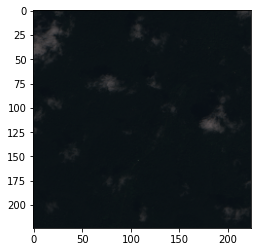

In [107]:
import matplotlib.pyplot as plt
image = np.load("images/6FJJ93MX+8XQ.npz")["arr_0"]
plt.imshow(image)